# Polynomial Regression
This file contains regression methodes: lineair regression on timeseries and polynomial regression on climate features vs production values. If you have no experience with Jupyter Notebook or Python, part of the results can be found [here](https://readmees.github.io/polynomial_fit.html).

# Import and preprocess data
To run this file you can press on 'Cell' and then on 'Run Cells'. You'll be asked multiple times to give input, this way you'll be able use the data in multiple ways. If you have more data in the future, you can add them in the same directory as the one with the Automonous Greenhouse Challenge teams. You can add new data by making a new directory. This directory needs to contain five csv files: Greenhouse_climate.csv, CropManagement.csv, Irrigation.csv, Production.csv and vip.csv. To run this specific code it's usefull to have the same features as the ones of the greenhouse challenge (see the data/DataReadMe.pdf file).

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize as minimize
from scipy.signal import find_peaks

# Import helper functions from polynomial_fit.py.
from polynomial_fit import *

In [2]:
# Loads in all the data in the data repository, except for the readme.
FileNotFound = True
while FileNotFound:
    try:
        directory = input("""Please add the directory you're data is in. 
         If you're using our original provided files this should be 'data'\n""")
        datasets = [filename for filename in os.listdir(directory)]
        FileNotFound = False
    except FileNotFoundError:
        print("Please add a valid directory")
        FileNotFound = True
try:
    datasets.remove('DataReadMe.pdf')
except ValueError:
    print('Warning: the DataReadMe.pdf file is removed, please visit https://github.com/readmees/erudite2020.git\
         to download it again')

Please add the directory you're data is in. 
         If you're using our original provided files this should be 'data'
data


In [3]:
# Creates Python dictionaries to be able to access all the different datasets.
data = {}
for dataset in datasets:
    GHClim = pd.read_csv(f"data/{dataset}/Greenhouse_climate.csv") 
    Crop = pd.read_csv(f"data/{dataset}/CropManagement.csv") 
    irri = pd.read_csv(f"data/{dataset}/Irrigation.csv") 
    prod = pd.read_csv(f"data/{dataset}/Production.csv") 
    vip = pd.read_csv(f"data/{dataset}/vip.csv") 
    GHClim = GHClim.drop(['VentLee', 'Ventwind', 'AssimLight', 'BlackScr', 'EnScr'], axis=1)
    
    # Fills all the NaN values except the ones in the first row.
    GHClim.fillna(method='ffill', inplace=True)
    Crop.fillna(method='ffill', inplace=True)
    irri.fillna(method='ffill', inplace=True)
    prod.fillna(method='ffill', inplace=True)
    vip.fillna(method='ffill', inplace=True)
    
    # Fills all the possible skipped NaN values.
    GHClim.fillna(method='bfill', inplace=True)
    Crop.fillna(method='bfill', inplace=True)
    irri.fillna(method='bfill', inplace=True)
    prod.fillna(method='bfill', inplace=True)
    vip.fillna(method='bfill', inplace=True)
    data[dataset] = {'GHClim':GHClim, 'Crop':Crop, 'irri':irri, 'prod':prod, 'vip':vip}

In [4]:
# Feature information is retrieved from the ReadMe.pdf from 
# the Automonous greenhouse challenge.
features_ghclim = {'Tair': ['Air temperature greenhouse', '°C'],
'RHair': ['Relative humidity greenhouse', '%'],
'CO2air': ['CO2 greenhouse', 'ppm'],
'HumDef': ['Humidity deficit', 'g/m3'],
'PipeLow': ['Lower circuit Temperature', '°C'],
'PipeGrow': ['Growth circuit Temperature', '°C']}

features_vip = {'CO2_Vip': ['CO2 setpoint', 'ppm'],
'HumDef_Vip': ['humidity deficit setpoint', 'g/kg'],
'MinPipeLow_Vip': ['net pipe minimum temperature setpoint', '°C'],
'MinPipeGrow_Vip': ['crop pipe minimum temperature setpoint', '°C']}

# Data visualization
Lets show how the features change with time, see the data/DataReadMe.pdf for more information about those features.

First of all a demonstration of the visualization of a single team/dataset, by default the Croperators. Since a lot of datapoint are the same for the teams, it's not always clear if there's only one datapoint measured or multiple. If you look closer, the points where multiple datapoints are measured are bigger points. This is not that userfriendly, which is why the regression line is added (which of course takes all datapoints into account).

In [ ]:
# Visualizes all the CO2air values over time for the Croperatures team,
# and checks if the Croperatures is still part of the dataset.
key = 'CO2air'
run = 'Maybe'
while run != 'Yes' and run != 'No':
    print('Please type Yes or No (case sensitive)')    
    run = str(input('''Is the Croperators dataset still part of your datasets?.
            [Yes/No]'''))
if run == 'Yes':
    visualize_time(data, ['Croperators'], key, features_ghclim[key][0], f'{key} in {features_ghclim[key][1]}')
else:
    while run != 'Yes':
        try:
            dataset = input('Which dataset would you like to show?\n')
            visualize_time(data, [dataset], key, features_ghclim[key][0], f'{key} in {features_ghclim[key][1]}')
            run = 'Yes'
        except KeyError:
            print('Please chose a valid dataset (case sensitive)')

## Greenhouse climate
The next visualisations will be of the GHClim dataset.

*Column heading Parameter description Unit Interval Dataset name Type Comments Data collection*
![](https://imgur.com/iAl45aq.png)

In [ ]:
# Plot timeseries, visualize_time is imported from polynomial_fit.py.
for key in features_ghclim:
    visualize_time(data, datasets, key, features_ghclim[key][0], f'{key} in {features_ghclim[key][1]}')

## Vip
The next visualisations will be of the Vip dataset

*Column heading Parameter description Unit Interval Dataset name Type Comments Data collection*
![](https://i.imgur.com/gm6EiUg.png)

In [ ]:
# Plot timeseries.
for key in features_vip:
    visualize_time(data, datasets, key, features_vip[key][0], f'{key} in {features_vip[key][1]}', 'vip', 'time')

# Weekly average

The feature GHtime is the timestamp per five minutes. Every time it changes with +- 0.0034722, this is $\frac{1}{1440}$ of a day: five minutes. So the GHtime is in days. One week is zeven days, so if we would like to take the average of every week, we would need to take the average of time the GHtime, changed by 7. 1 week is 10080 minutes. So 1 week is $\frac{10080}{5}$ timestamps, so 2016 timestamps.

In [5]:
# Check if the user would like to devide the data in weekly data.
run = 'Maybe'
while run != 'Yes' and run != 'No':
    print('Please type Yes or No (case sensitive)')    
    run = str(input('''
            Would you like to divide the data in weekly data? 
            If you choose No, the average of the features per dataset
            will be calculated.\n[Yes/No]'''))

# Devide the data in weekly data.
if run == 'Yes':
    weekly_data = calculate_weekly_data(features_ghclim.keys(), data, datasets)

Please type Yes or No (case sensitive)

            Would you like to divide the data in weekly data? 
            If you choose No, the average of the features per dataset
            will be calculated.
[Yes/No]Yes
The code is succesfully runned and the data is devided in weekly data (see the 'weekly_data' variable)


# Polynomial fitting
## On greenhouse climate data versus production A and B

Which degree of polynomial fitting would you like?
3
Tair


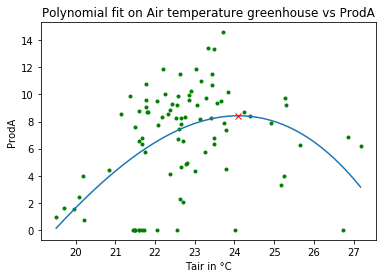

The optimal value(s) according to a polynomial
with a degree of 3: 24.099045870876175.
RHair


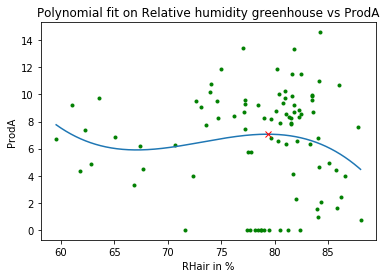

The optimal value(s) according to a polynomial
with a degree of 3: 79.35279458644595.
CO2air


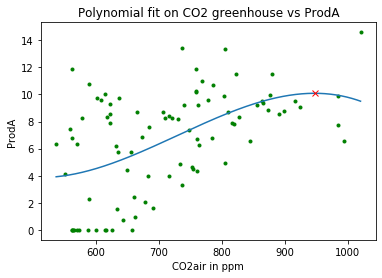

The optimal value(s) according to a polynomial
with a degree of 3: 947.475264901824.
HumDef


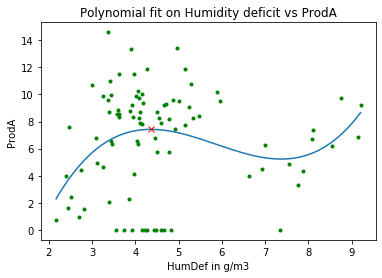

The optimal value(s) according to a polynomial
with a degree of 3: 4.35333481046694.
PipeLow


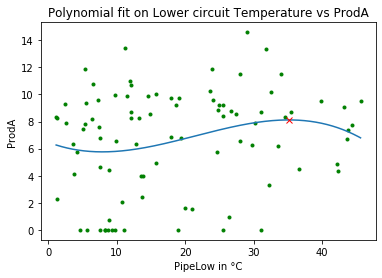

The optimal value(s) according to a polynomial
with a degree of 3: 35.119274508147164.
PipeGrow


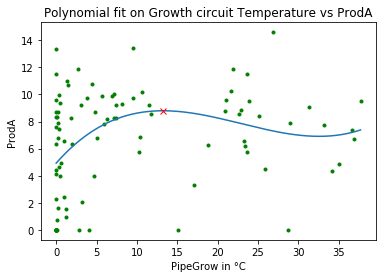

The optimal value(s) according to a polynomial
with a degree of 3: 13.256350546036481.
Tair


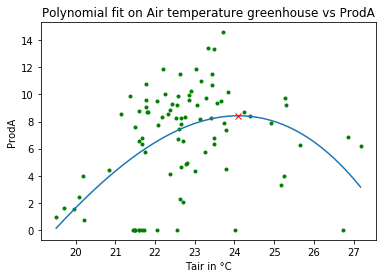

The optimal value(s) according to a polynomial
with a degree of 3: 24.099045870876175.
RHair


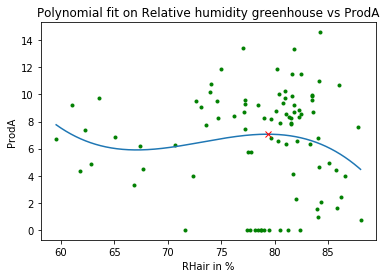

The optimal value(s) according to a polynomial
with a degree of 3: 79.35279458644595.
CO2air


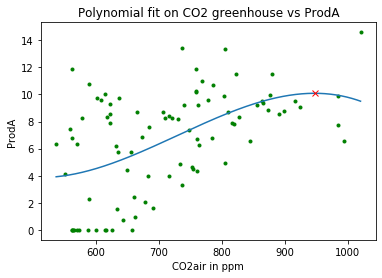

The optimal value(s) according to a polynomial
with a degree of 3: 947.475264901824.
HumDef


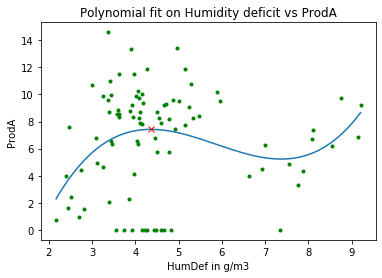

The optimal value(s) according to a polynomial
with a degree of 3: 4.35333481046694.
PipeLow


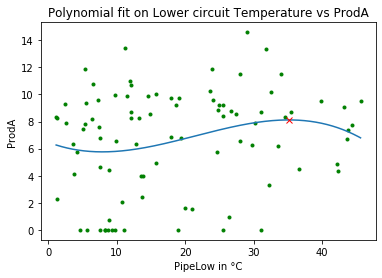

The optimal value(s) according to a polynomial
with a degree of 3: 35.119274508147164.
PipeGrow


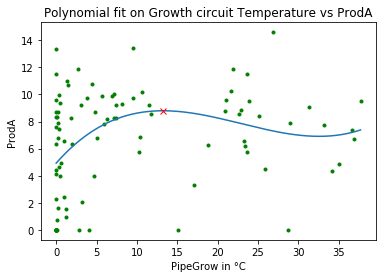

The optimal value(s) according to a polynomial
with a degree of 3: 13.256350546036481.


In [6]:
def plot_polynome(x,y, degree, x_name, y_name):
    '''
    This function visualizes data and a fitted polynomial. In this function a good 
    fit for a certain degree polynomial will be found. The degree has to be a given
    parameter. x and y are the datapoints and x_name and y_name are the names of this
    datasets.
    '''
    print(x_name)
    plt.plot(x, y, '.g')
    params = np.polyfit(x,y, degree)
    
    # The more samples on the linspace, the more accurate the local maxima will be.
    x_polynome = np.linspace(min(x),max(x),1000)
    y_polynome = np.poly1d(params)(x_polynome)
    plt.plot(x_polynome, y_polynome)
    
    # Find the maximum values.
    peaks, _ = find_peaks(y_polynome, height=0)
    plt.plot(x_polynome[peaks], y_polynome[peaks], 'xr')
    plt.xlabel(f'{x_name} in {features_ghclim[x_name][1]}')
    plt.ylabel(y_name)
    plt.title(f'Polynomial fit on {features_ghclim[x_name][0]} vs {y_name}')
    plt.show()
    print(f'The optimal value(s) according to a polynomial\nwith a degree of {degree}:', end=" ")
    peaks_str = ""
    for val in x_polynome[peaks]:
        peaks_str += f'{val}, '
    print(peaks_str[:-2]+'.')

# Ask for input.
degree = 0
while not 2<=degree<=20:
    try:
        degree = int(input('Which degree of polynomial fitting would you like?\n'))
        if not 2<=degree<=20:
            print('Please chose an integer (a high degree polynomial may overfit)')
    except ValueError:
        print('Please chose an integer (a high degree polynomial may overfit)')
if run == 'Yes':
    for y_name in ['ProdA_num', 'ProdA_num']:
        for key in features_ghclim:
            x, y = weekly_data[key], weekly_data[y_name]
            plot_polynome(x,y, degree, key, y_name[:5])
else:
    # Take the average of the ghclim features and the eventual production value of every team.
    plot_data = dict()
    for category in ['ProdA_cum', 'ProdB_cum']:
        for key in features_ghclim:
            feature_point, prod = [], []
            for dataset in datasets:
                feature_point.append(data[dataset]['GHClim'][key].mean())
                prod_df = data[dataset]['prod'][category]
                prod.append(prod_df[prod_df.index[-1]])
            x, y = feature_point, prod
            plot_polynome(x,y, degree, key, category[:5])

# Results
*More results can be found in the [README.md](https://github.com/readmees/erudite2020/blob/master/README.md) and on the webpage mentioned in the start of this file: [readmees.github.io/polynomial_fit.html](https://readmees.github.io/polynomial_fit.html).*

As you can see in the following figure, according to Zheng et al. (2018) the optimal CO growth for three perennial grass species is around 915 ppm. If you fit an 3rd degree polynomial on the automonous greenhouse challenge data you will get a simulair result, +- 947.475264901824 ppm (see figure 2)
![](https://media.springernature.com/full/springer-static/image/art%3A10.1186%2Fs12870-018-1243-3/MediaObjects/12870_2018_1243_Fig1_HTML.gif?as=webp)
Figure 1: Zheng, Y., Li, F., Hao, L., Shedayi, A. A., Guo, L., Ma, C., ... & Xu, M. (2018). The optimal CO 2 concentrations for the growth of three perennial grass species. BMC plant biology, 18(1), 27.
![](https://i.imgur.com/eA9OZZi.png)
Figure 2: Automonous greenhouse challenge data